In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler


data_path = '2002-02-01.csv'
df = pd.read_csv(data_path, header=0)

df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
df.dropna(inplace=True)

for col in df.columns[1:]:
    df[col] = df[col].astype(float)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

features_to_scale = df.columns[2:]
df[features_to_scale] = scaler_X.fit_transform(df[features_to_scale])

df[['Open']] = scaler_y.fit_transform(df[['Open']])

if df.isnull().values.any():
    print("NaN values introduced after scaling.")
else:
    print("No NaN values found after scaling.")

print(df.head())

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length), 1:].to_numpy()
        y = data.iloc[i + seq_length, 1]
        if not np.isnan(x).any() and np.isfinite(y):
            xs.append(x)
            ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 100

X, y = create_sequences(df, seq_length)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


assert not np.isnan(X).any() and not np.isnan(y).any(), "NaN values found in sequences"

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, shuffle=False)

print("Shapes of datasets:")
print("X_train_full:", X_train_full.shape)
print("X_test:", X_test.shape)
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)

total_length = X_train_full.shape[0] + X_test.shape[0]
expected_length = X.shape[0]
print("Total length of train_full and test:", total_length)
print("Expected total length:", expected_length)

last_batch_size = len(X_test) % 4
print("Last batch size in test set:", last_batch_size)

val_start_index = len(X) - len(X_test) - len(X_val)
val_end_index = val_start_index + len(X_val)
validation_dates = df['Date'].iloc[val_start_index:val_end_index]
print("validation dates:",validation_dates)

test_start_index = len(X) - len(X_test)
test_dates = df['Date'].iloc[test_start_index:]
print("test dates:",test_dates)

df.replace([np.inf, -np.inf], np.nan, inplace=True)

df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

assert not df.isnull().any().any(), "Data still contains NaN after all replacements."
# assert not np.isinf(df.values).any(), "Data contains infinity after all replacements."

df.to_csv('/Users/s/Downloads/time_series_apple/AI6123_Time_Series_Assignment_3 (Answer to part 1)/APPL_after_feature_engineering_and_cleaning.csv', index=False)

print("testing set:",len(X_test))
print("training set:",len(X_train))
print("validation set:",len(X_val))

# find columns with NaN values
nan_columns = df.columns[df.isna().any()].tolist()
print(f"Columns with NaN: {nan_columns}")

# find rows with NaN values
nan_rows = df[df.isna().any(axis=1)]
print(f"Rows with NaN:\n{nan_rows}")

No NaN values found after scaling.
       Date      Open      High       Low     Close  Adj Close    Volume  \
0  2/1/2002 -0.749353 -0.749194 -0.749052 -0.749165  -0.725538  0.016423   
1  2/4/2002 -0.749360 -0.749012 -0.749099 -0.748857  -0.725276  0.340033   
2  2/5/2002 -0.749107 -0.748863 -0.748807 -0.748824  -0.725248  0.169223   
3  2/6/2002 -0.748940 -0.748863 -0.749115 -0.749080  -0.725466  0.536186   
4  2/7/2002 -0.749252 -0.749087 -0.749139 -0.749201  -0.725569 -0.115227   

     SMA_20    EMA_12    EMA_26    RSI_14      MACD  MACD_Signal  BB_Middle  \
0 -0.748218 -0.748809 -0.748123  0.949177 -0.157863    -0.172247  -0.748218   
1 -0.748190 -0.748706 -0.748057  1.106727 -0.156300    -0.171278  -0.748190   
2 -0.748148 -0.748614 -0.747993  1.026473 -0.155090    -0.170246  -0.748148   
3 -0.748114 -0.748576 -0.747953  1.101549 -0.155151    -0.169434  -0.748114   
4 -0.748070 -0.748562 -0.747925  0.484545 -0.155749    -0.168911  -0.748070   

   BB_Upper  BB_Lower      VWAP  

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, n_hidden):
        super(Attention, self).__init__()
        self.attention_weights = nn.Parameter(torch.Tensor(n_hidden, n_hidden))
        nn.init.xavier_uniform_(self.attention_weights.data, gain=1.414)

    def forward(self, lstm_out):
        attn_scores = torch.matmul(lstm_out, self.attention_weights)
        attn_weights = nn.functional.softmax(attn_scores, dim=2)
        weighted_sum = torch.sum(attn_weights * lstm_out, dim=1)
        return weighted_sum

class StockPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(StockPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=0.2,
            batch_first=True,
            bidirectional=True
        )
        self.attention = Attention(n_hidden * 2)
        self.linear1 = nn.Linear(in_features=n_hidden * 2, out_features=64)
        self.linear2 = nn.Linear(in_features=64, out_features=32)  # 新的全连接层
        self.linear3 = nn.Linear(in_features=32, out_features=1)
        self.residual_layer = nn.Linear(n_features, n_hidden * 2)  # 与 attn_output 匹配

    def forward(self, sequences):
        lstm_out, _ = self.lstm(sequences)
        attn_output = self.attention(lstm_out)
        residual = self.residual_layer(sequences[:, -1, :])
        combined_output = attn_output + residual  # 两个张量形状匹配
        y_pred = self.linear1(combined_output)
        y_pred = self.linear2(y_pred)  # 经过新的全连接层
        y_pred = self.linear3(y_pred)
        return y_pred

import torch.nn.init as init

def init_weights(m):
    if type(m) == nn.Linear:
        init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)
    elif type(m) == nn.LSTM:
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

model = StockPredictor(
    n_features=16,   # 根据输入特征数量调整
    n_hidden=128,
    seq_len=seq_length,
    n_layers=3
)

# model = StockPredictor(n_features=16, n_hidden=64, seq_len=seq_length, n_layers=1)

model.apply(init_weights)

StockPredictor(
  (lstm): LSTM(16, 128, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (attention): Attention()
  (linear1): Linear(in_features=256, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=1, bias=True)
  (residual_layer): Linear(in_features=16, out_features=256, bias=True)
)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<ipython-input-5-463d63db8865>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
<ipython-input-5-463d63db8865>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
<ipython-input-5-463d63db8865>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
<ipython-input-5-463d63db8865>:64: UserWarning: To copy construct from a tensor, it is recommended t

Epoch 1/50, Train Loss: 0.2288, Val Loss: 0.1854
Learning Rate adjusted to: 1e-05
Model improved and saved as 20240502103925_epoch_1_val_loss_0.1854.pt


Training Progress:   4%|▍         | 2/50 [00:25<10:17, 12.86s/it]

Epoch 2/50, Train Loss: 0.0174, Val Loss: 0.1207
Learning Rate adjusted to: 1e-05
Model improved and saved as 20240502103938_epoch_2_val_loss_0.1207.pt


Training Progress:   6%|▌         | 3/50 [00:38<09:58, 12.73s/it]

Epoch 3/50, Train Loss: 0.0122, Val Loss: 0.0755
Learning Rate adjusted to: 1e-05
Model improved and saved as 20240502103950_epoch_3_val_loss_0.0755.pt


Training Progress:   8%|▊         | 4/50 [00:50<09:40, 12.63s/it]

Epoch 4/50, Train Loss: 0.0098, Val Loss: 0.0760
Learning Rate adjusted to: 1e-05


Training Progress:  10%|█         | 5/50 [01:03<09:27, 12.60s/it]

Epoch 5/50, Train Loss: 0.0086, Val Loss: 0.0629
Learning Rate adjusted to: 1e-05
Model improved and saved as 20240502104015_epoch_5_val_loss_0.0629.pt


Training Progress:  12%|█▏        | 6/50 [01:16<09:13, 12.58s/it]

Epoch 6/50, Train Loss: 0.0082, Val Loss: 0.0532
Learning Rate adjusted to: 1e-05
Model improved and saved as 20240502104028_epoch_6_val_loss_0.0532.pt


Training Progress:  14%|█▍        | 7/50 [01:28<08:59, 12.56s/it]

Epoch 7/50, Train Loss: 0.0074, Val Loss: 0.0534
Learning Rate adjusted to: 1e-05


Training Progress:  16%|█▌        | 8/50 [01:41<08:46, 12.54s/it]

Epoch 8/50, Train Loss: 0.0068, Val Loss: 0.0410
Learning Rate adjusted to: 1e-05
Model improved and saved as 20240502104053_epoch_8_val_loss_0.0410.pt


Training Progress:  18%|█▊        | 9/50 [01:53<08:33, 12.51s/it]

Epoch 9/50, Train Loss: 0.0069, Val Loss: 0.0422
Learning Rate adjusted to: 1e-05


Training Progress:  20%|██        | 10/50 [02:06<08:20, 12.52s/it]

Epoch 10/50, Train Loss: 0.0060, Val Loss: 0.0497
Learning Rate adjusted to: 1e-05


Training Progress:  22%|██▏       | 11/50 [02:18<08:08, 12.52s/it]

Epoch 11/50, Train Loss: 0.0057, Val Loss: 0.0396
Learning Rate adjusted to: 1e-05
Model improved and saved as 20240502104130_epoch_11_val_loss_0.0396.pt


Training Progress:  24%|██▍       | 12/50 [02:31<07:55, 12.53s/it]

Epoch 12/50, Train Loss: 0.0052, Val Loss: 0.0238
Learning Rate adjusted to: 1e-05
Model improved and saved as 20240502104143_epoch_12_val_loss_0.0238.pt


Training Progress:  26%|██▌       | 13/50 [02:43<07:42, 12.51s/it]

Epoch 13/50, Train Loss: 0.0046, Val Loss: 0.0298
Learning Rate adjusted to: 1e-05


Training Progress:  28%|██▊       | 14/50 [02:56<07:30, 12.52s/it]

Epoch 14/50, Train Loss: 0.0045, Val Loss: 0.0274
Learning Rate adjusted to: 1e-05


Training Progress:  30%|███       | 15/50 [03:08<07:17, 12.50s/it]

Epoch 15/50, Train Loss: 0.0047, Val Loss: 0.0276
Learning Rate adjusted to: 1e-05


Training Progress:  32%|███▏      | 16/50 [03:21<07:04, 12.49s/it]

Epoch 16/50, Train Loss: 0.0042, Val Loss: 0.0177
Learning Rate adjusted to: 1e-05
Model improved and saved as 20240502104233_epoch_16_val_loss_0.0177.pt


Training Progress:  34%|███▍      | 17/50 [03:33<06:51, 12.48s/it]

Epoch 17/50, Train Loss: 0.0038, Val Loss: 0.0113
Learning Rate adjusted to: 1e-05
Model improved and saved as 20240502104245_epoch_17_val_loss_0.0113.pt


Training Progress:  36%|███▌      | 18/50 [03:45<06:39, 12.48s/it]

Epoch 18/50, Train Loss: 0.0036, Val Loss: 0.0142
Learning Rate adjusted to: 1e-05


Training Progress:  38%|███▊      | 19/50 [03:58<06:26, 12.48s/it]

Epoch 19/50, Train Loss: 0.0035, Val Loss: 0.0203
Learning Rate adjusted to: 1e-05


Training Progress:  40%|████      | 20/50 [04:11<06:15, 12.51s/it]

Epoch 20/50, Train Loss: 0.0037, Val Loss: 0.0157
Learning Rate adjusted to: 1e-05


Training Progress:  42%|████▏     | 21/50 [04:23<06:03, 12.52s/it]

Epoch 21/50, Train Loss: 0.0030, Val Loss: 0.0122
Learning Rate adjusted to: 1e-05


Training Progress:  44%|████▍     | 22/50 [04:36<05:51, 12.55s/it]

Epoch 22/50, Train Loss: 0.0030, Val Loss: 0.0158
Learning Rate adjusted to: 1e-05


Training Progress:  46%|████▌     | 23/50 [04:48<05:39, 12.58s/it]

Epoch 23/50, Train Loss: 0.0032, Val Loss: 0.0140
Learning Rate adjusted to: 5e-06


Training Progress:  48%|████▊     | 24/50 [05:01<05:27, 12.59s/it]

Epoch 24/50, Train Loss: 0.0024, Val Loss: 0.0139
Learning Rate adjusted to: 5e-06


Training Progress:  50%|█████     | 25/50 [05:14<05:15, 12.60s/it]

Epoch 25/50, Train Loss: 0.0022, Val Loss: 0.0120
Learning Rate adjusted to: 5e-06


Training Progress:  52%|█████▏    | 26/50 [05:26<05:02, 12.60s/it]

Epoch 26/50, Train Loss: 0.0022, Val Loss: 0.0120
Learning Rate adjusted to: 5e-06


Training Progress:  54%|█████▍    | 27/50 [05:39<04:50, 12.61s/it]

Epoch 27/50, Train Loss: 0.0021, Val Loss: 0.0101
Learning Rate adjusted to: 5e-06
Model improved and saved as 20240502104451_epoch_27_val_loss_0.0101.pt


Training Progress:  56%|█████▌    | 28/50 [05:51<04:37, 12.62s/it]

Epoch 28/50, Train Loss: 0.0021, Val Loss: 0.0134
Learning Rate adjusted to: 5e-06


Training Progress:  58%|█████▊    | 29/50 [06:04<04:24, 12.61s/it]

Epoch 29/50, Train Loss: 0.0021, Val Loss: 0.0121
Learning Rate adjusted to: 5e-06


Training Progress:  60%|██████    | 30/50 [06:17<04:12, 12.63s/it]

Epoch 30/50, Train Loss: 0.0020, Val Loss: 0.0132
Learning Rate adjusted to: 5e-06


Training Progress:  62%|██████▏   | 31/50 [06:29<03:59, 12.63s/it]

Epoch 31/50, Train Loss: 0.0020, Val Loss: 0.0104
Learning Rate adjusted to: 5e-06


Training Progress:  64%|██████▍   | 32/50 [06:42<03:47, 12.64s/it]

Epoch 32/50, Train Loss: 0.0021, Val Loss: 0.0106
Learning Rate adjusted to: 5e-06


Training Progress:  66%|██████▌   | 33/50 [06:55<03:34, 12.63s/it]

Epoch 33/50, Train Loss: 0.0020, Val Loss: 0.0107
Learning Rate adjusted to: 2.5e-06


Training Progress:  68%|██████▊   | 34/50 [07:07<03:22, 12.65s/it]

Epoch 34/50, Train Loss: 0.0016, Val Loss: 0.0111
Learning Rate adjusted to: 2.5e-06


Training Progress:  70%|███████   | 35/50 [07:20<03:09, 12.64s/it]

Epoch 35/50, Train Loss: 0.0017, Val Loss: 0.0112
Learning Rate adjusted to: 2.5e-06


Training Progress:  72%|███████▏  | 36/50 [07:33<02:57, 12.65s/it]

Epoch 36/50, Train Loss: 0.0017, Val Loss: 0.0128
Learning Rate adjusted to: 2.5e-06


Training Progress:  74%|███████▍  | 37/50 [07:45<02:44, 12.65s/it]

Epoch 37/50, Train Loss: 0.0017, Val Loss: 0.0110
Learning Rate adjusted to: 2.5e-06


Training Progress:  76%|███████▌  | 38/50 [07:58<02:31, 12.64s/it]

Epoch 38/50, Train Loss: 0.0017, Val Loss: 0.0115
Learning Rate adjusted to: 2.5e-06


Training Progress:  78%|███████▊  | 39/50 [08:10<02:19, 12.64s/it]

Epoch 39/50, Train Loss: 0.0017, Val Loss: 0.0116
Learning Rate adjusted to: 1.25e-06


Training Progress:  80%|████████  | 40/50 [08:23<02:06, 12.63s/it]

Epoch 40/50, Train Loss: 0.0015, Val Loss: 0.0114
Learning Rate adjusted to: 1.25e-06


Training Progress:  82%|████████▏ | 41/50 [08:36<01:53, 12.64s/it]

Epoch 41/50, Train Loss: 0.0015, Val Loss: 0.0111
Learning Rate adjusted to: 1.25e-06


Training Progress:  84%|████████▍ | 42/50 [08:48<01:41, 12.64s/it]

Epoch 42/50, Train Loss: 0.0015, Val Loss: 0.0114
Learning Rate adjusted to: 1.25e-06


Training Progress:  86%|████████▌ | 43/50 [09:01<01:28, 12.65s/it]

Epoch 43/50, Train Loss: 0.0015, Val Loss: 0.0111
Learning Rate adjusted to: 1.25e-06


Training Progress:  88%|████████▊ | 44/50 [09:14<01:15, 12.66s/it]

Epoch 44/50, Train Loss: 0.0015, Val Loss: 0.0116
Learning Rate adjusted to: 1.25e-06


Training Progress:  90%|█████████ | 45/50 [09:26<01:03, 12.65s/it]

Epoch 45/50, Train Loss: 0.0015, Val Loss: 0.0112
Learning Rate adjusted to: 6.25e-07


Training Progress:  92%|█████████▏| 46/50 [09:39<00:50, 12.65s/it]

Epoch 46/50, Train Loss: 0.0014, Val Loss: 0.0112
Learning Rate adjusted to: 6.25e-07


Training Progress:  94%|█████████▍| 47/50 [09:52<00:37, 12.66s/it]

Epoch 47/50, Train Loss: 0.0014, Val Loss: 0.0111
Learning Rate adjusted to: 6.25e-07


Training Progress:  96%|█████████▌| 48/50 [10:04<00:25, 12.66s/it]

Epoch 48/50, Train Loss: 0.0014, Val Loss: 0.0109
Learning Rate adjusted to: 6.25e-07


Training Progress:  98%|█████████▊| 49/50 [10:17<00:12, 12.65s/it]

Epoch 49/50, Train Loss: 0.0014, Val Loss: 0.0110
Learning Rate adjusted to: 6.25e-07


Training Progress: 100%|██████████| 50/50 [10:30<00:00, 12.60s/it]


Epoch 50/50, Train Loss: 0.0014, Val Loss: 0.0112
Learning Rate adjusted to: 6.25e-07


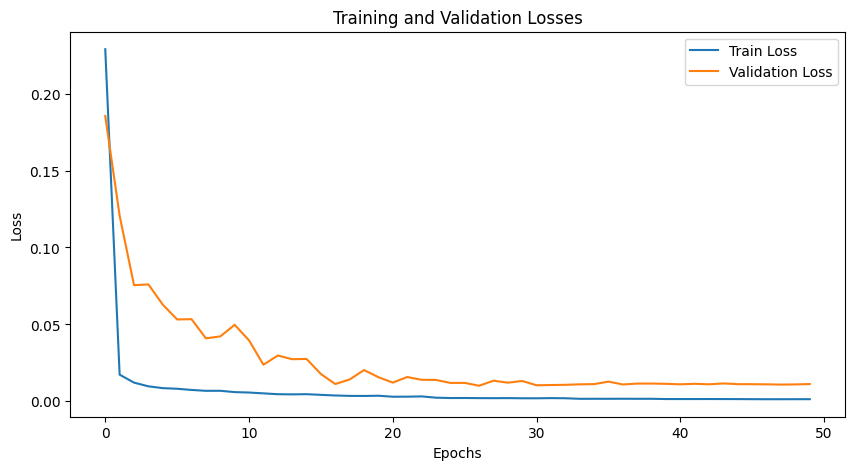

<ipython-input-5-463d63db8865>:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_pred = model(torch.tensor(X_val, dtype=torch.float32).to(device))


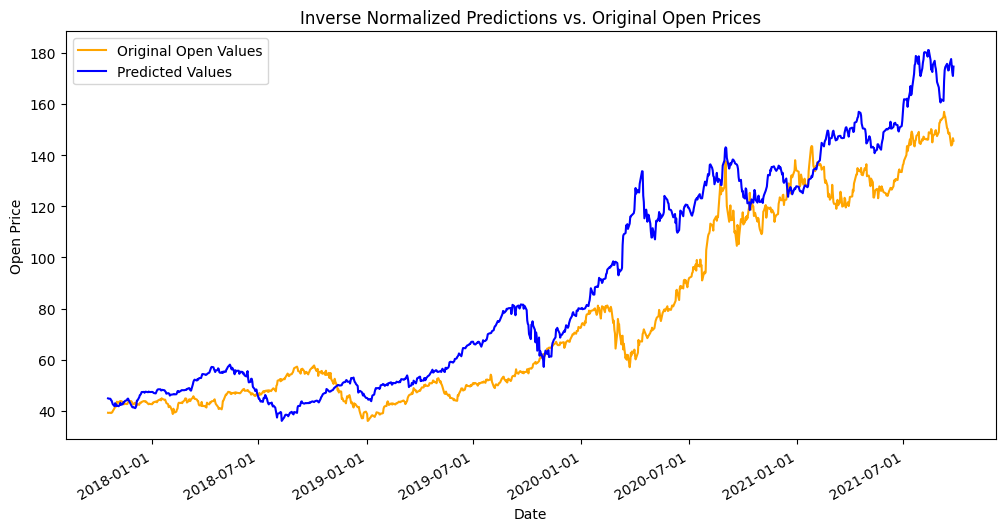

Original scale predictions: [[ 44.82551 ]
 [ 44.728397]
 [ 44.658634]
 [ 44.121746]
 [ 43.978603]
 [ 43.305206]
 [ 42.540474]
 [ 41.77735 ]
 [ 42.92583 ]
 [ 42.690475]
 [ 41.872826]
 [ 42.108902]
 [ 41.756996]
 [ 42.032516]
 [ 42.334152]
 [ 43.1101  ]
 [ 42.30535 ]
 [ 42.548546]
 [ 43.30357 ]
 [ 43.18842 ]
 [ 43.592773]
 [ 43.84765 ]
 [ 44.110584]
 [ 44.654358]
 [ 44.733932]
 [ 43.680107]
 [ 42.32918 ]
 [ 41.88677 ]
 [ 41.455242]
 [ 41.30367 ]
 [ 41.40844 ]
 [ 40.995033]
 [ 41.271877]
 [ 42.087727]
 [ 43.942913]
 [ 44.010757]
 [ 45.295776]
 [ 46.099545]
 [ 46.23767 ]
 [ 46.64315 ]
 [ 47.281105]
 [ 47.315315]
 [ 47.344803]
 [ 47.02424 ]
 [ 47.389076]
 [ 47.4212  ]
 [ 47.23783 ]
 [ 47.480938]
 [ 47.361584]
 [ 47.292336]
 [ 47.352367]
 [ 47.29619 ]
 [ 47.034058]
 [ 46.897797]
 [ 46.761745]
 [ 47.296646]
 [ 47.87317 ]
 [ 48.20782 ]
 [ 48.367844]
 [ 48.377625]
 [ 47.935516]
 [ 47.94809 ]
 [ 48.160835]
 [ 48.02891 ]
 [ 47.982403]
 [ 47.570827]
 [ 47.371975]
 [ 46.658897]
 [ 46.87713 ]
 [ 46.

In [5]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import sys
import torch.nn.functional as F


best_val_loss = float('inf')

class CombinedLoss(torch.nn.Module):
    def __init__(self, quantile=0.5):
        super().__init__()
        self.quantile = quantile

    def quantile_loss(self, y_pred, y_true):
        error = y_true - y_pred
        return torch.mean(torch.max(self.quantile * error, (self.quantile - 1) * error))

    # def trend_loss(self, y_pred, y_true):
    #     if y_pred.ndim == 0 or y_true.ndim == 0 or len(y_pred) < 2:
    #         return torch.tensor(0.0).to(y_pred.device)
    #     trend_pred = torch.sign(y_pred[1:] - y_pred[:-1])
    #     trend_true = torch.sign(y_true[1:] - y_true[:-1])
    #     trend_disagreement = torch.mean((trend_pred != trend_true).float())
    #     return trend_disagreement

    def forward(self, y_pred, y_true):
        y_pred = y_pred.squeeze()

        y_true = y_true.squeeze()

        mse_loss = torch.nn.functional.mse_loss(y_pred, y_true) * 0.05
        smooth_l1_loss = F.smooth_l1_loss(y_pred, y_true) * 0.1
        mae_loss = torch.nn.functional.l1_loss(y_pred, y_true) * 0.45
        quantile_loss = self.quantile_loss(y_pred, y_true) * 0.4
        # trend_loss = self.trend_loss(y_pred, y_true) * 0.05

        return mse_loss + smooth_l1_loss + mae_loss + quantile_loss


def check_gradients(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = torch.norm(param.grad)
            if torch.isnan(grad_norm) or torch.isinf(grad_norm):
                print(f"Gradient for {name} is NaN or inf.")

def train_model(model, X_train, y_train, X_val, y_val, num_epochs=50, batch_size=4, learning_rate=0.00001, weight_decay = 0.01):

    # orig_stdout = sys.stdout
    # f = open('result.log', 'w')
    # sys.stdout = f

    global best_val_loss

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)


    # model_path = ''
    # model = StockPredictor(n_features=16, n_hidden=128, seq_len=100, n_layers=3)
    # model.load_state_dict(torch.load(model_path, map_location=device))

    model.to(device)
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
    combined_loss_fn = CombinedLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        model.train()
        total_train_loss = 0

        for x_batch, y_batch in train_loader:
            # print("Input data stats:", x_batch.min(), x_batch.max(), x_batch.mean())
            optimizer.zero_grad()
            y_pred = model(x_batch)
            # print("Output stats:", y_pred.data.min(), y_pred.data.max(), y_pred.data.mean())
            loss = combined_loss_fn(y_pred, y_batch)
            # print("Loss:", loss.item())
            loss.backward()

            nan_gradients = False
            for name, param in model.named_parameters():
                if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
                    print(f"NaN or Inf in gradients of {name}")
                    nan_gradients = True

            if nan_gradients:
                print("NaN or Inf gradients detected. Exiting training loop.")
                break

            check_gradients(model)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 梯度裁剪
            optimizer.step()
            total_train_loss += loss.item() * x_batch.size(0)

        avg_train_loss = total_train_loss / len(X_train)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                y_pred = model(x_batch)
                loss = combined_loss_fn(y_pred, y_batch)
                total_val_loss += loss.item() * x_batch.size(0)

        avg_val_loss = total_val_loss / len(X_val)
        val_losses.append(avg_val_loss)
        tqdm.write(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning Rate adjusted to: {current_lr}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            current_time = time.strftime("%Y%m%d%H%M%S", time.localtime())
            model_name = f"{current_time}_epoch_{epoch+1}_val_loss_{avg_val_loss:.4f}.pt"
            torch.save(model.state_dict(), model_name)
            print(f"Model improved and saved as {model_name}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_validation_losses.png')
    plt.show()

    import matplotlib.dates as mdates

    data_path = 'filtered_stock_data.csv'
    df = pd.read_csv(data_path, header=0, parse_dates=['Date'])

    original_open_values = df['Open'].values
    dates = df['Date'].values

    y_val_pred = model(torch.tensor(X_val, dtype=torch.float32).to(device))
    y_val_pred = y_val_pred.cpu().detach().numpy()
    y_val_pred_rescaled = scaler_y.inverse_transform(y_val_pred.reshape(-1, 1))

    # get the validation dates
    validation_start_date = pd.Timestamp('2017-10-19')
    validation_end_date = pd.Timestamp('2021-09-24')
    validation_dates = df[(df['Date'] >= validation_start_date) & (df['Date'] <= validation_end_date)]['Date']

    # get the validation open values
    validation_open_values = df[(df['Date'] >= validation_start_date) & (df['Date'] <= validation_end_date)]['Open']

    # plot the original and predicted values
    plt.figure(figsize=(12, 6))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.plot(validation_dates, validation_open_values, color='orange', label='Original Open Values')
    plt.plot(validation_dates, y_val_pred_rescaled, color='blue', label='Predicted Values')
    plt.title('Inverse Normalized Predictions vs. Original Open Prices')
    plt.xlabel('Date')
    plt.ylabel('Open Price')
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.savefig('inverse_normalized_predictions_with_original.png')
    plt.show()

    print("Original scale predictions:", y_val_pred_rescaled)

      # sys.stdout = orig_stdout
      # f.close()

train_model(model, X_train, y_train, X_val, y_val)


Test MAPE: 1.2051%


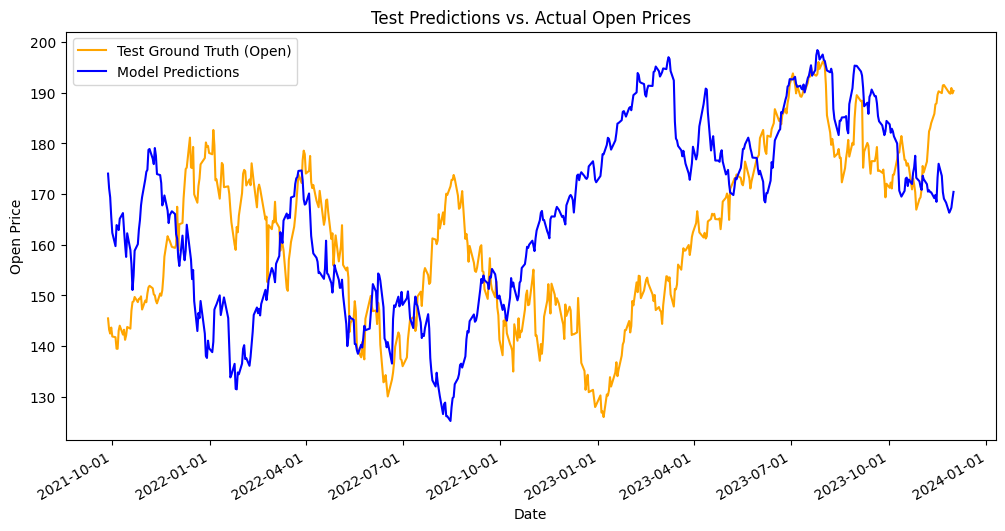

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = '/content/20240502104451_epoch_27_val_loss_0.0101.pt'
model = StockPredictor(n_features=16, n_hidden=128, seq_len=100, n_layers=3)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

data_path = '/content/filtered_stock_data.csv'
df = pd.read_csv(data_path, parse_dates=['Date'])

test_dates = df[(df['Date'] >= pd.Timestamp('2021-09-27')) & (df['Date'] <= pd.Timestamp('2023-12-01'))]['Date']
test_open_values = df[(df['Date'] >= pd.Timestamp('2021-09-27')) & (df['Date'] <= pd.Timestamp('2023-12-01'))]['Open'].values

X_test_tensor = X_test.clone().detach().to(device)
y_test_tensor = y_test.clone().detach().to(device)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

predictions_list = []
total_mape = 0.0
num_samples = 0
epsilon = 1e-8

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        predictions = model(X_test_batch)
        predictions_list.append(predictions.cpu().numpy())

        # calculate MAPE
        absolute_errors = torch.abs(predictions - y_test_batch.unsqueeze(1))
        relative_errors = absolute_errors / (y_test_batch.unsqueeze(1) + epsilon)
        mape = torch.mean(relative_errors).item() * 100
        total_mape += mape * X_test_batch.size(0)
        num_samples += X_test_batch.size(0)

predictions_array = np.concatenate(predictions_list).flatten()
predictions_rescaled = scaler_y.inverse_transform(predictions_array.reshape(-1, 1))

# calculate total MAPE
average_mape = total_mape / num_samples
print(f'Test MAPE: {average_mape:.4f}%')

plt.figure(figsize=(12, 6))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(test_dates, test_open_values, color='orange', label='Test Ground Truth (Open)')
plt.plot(test_dates, predictions_rescaled, color='blue', label='Model Predictions')
plt.title('Test Predictions vs. Actual Open Prices')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.gcf().autofmt_xdate()  # rotate x-axis labels for better readability
plt.show()